# File reading and parsing

Group project for the 2019 Data Science Workshop at the University of California, Berkeley.

The project is the Google Analytics Customer Revenue Prediction competition on Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction

Group members:

* Andy Vargas (mentor)
* Yuem Park
* Marvin Pohl
* Michael Yeh

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import ast
from pandas.io.json import json_normalize
import pandas_profiling as pp
import math
import datetime
import seaborn as sn

pd.options.display.max_columns = 999

Load data:

Note that the data files are too large to upload to GitHub - instead, the directory `./data/` has been added to the .gitignore, which should contain the following files on your local machine, all downloaded from the Kaggle competition website:

* sample_submission_v2.csv
* test_v2.csv
* train_v2.csv

Some of the columns are in JSON format - the following function (taken from [here](https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue)) flattens the JSON columns, such that we end up with a more typical data table, where each column has a single feature in it:

In [4]:
def load_df(csv_path=None, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'] # columns of the dataframe that can readily be converted
    JSON_COLUMNS2 = ['customDimensions','device', 'geoNetwork', 'totals', 'trafficSource'] # columns of the dataframe that need to be tweaked

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, # convert JSON_COLUMNS to json format
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for row in list(range(nrows)): # fill empty elements in column 'customDimensions' and 
        if df['customDimensions'][row] == '[]':
            df['customDimensions'][row] = "{'index':'','value':''}"
    
    df['customDimensions'] = df['customDimensions'].str.replace("[", '') # drop square brackets in column 'customDimensions'
    df['customDimensions'] = df['customDimensions'].str.replace("]", '')
    df['customDimensions'] = df['customDimensions'].str.replace("'", "\"")
    
    for row in list(range(nrows)): # convert strings in 'customDimensions' to dict
        df['customDimensions'][row] = json.loads(df['customDimensions'][row])
        
    for column in JSON_COLUMNS2: # distribute the dicts to separate columns of the dataframe
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
    return df

In [ ]:
def hits_converter(data):
    return json.loads(json.dumps(ast.literal_eval(data)))

def customDimensions_converter(data):
    if data == '[]':
        return {}
    else:
        return hits_converter(data)[0]

def load_df(csv_path='data/train_v2.csv', nrows=None):
    
    conv_dict = {'device': json.loads,
                'geoNetwork': json.loads,
                'totals': json.loads,
                'trafficSource': json.loads,
                'hits': hits_converter,
                'customDimensions': customDimensions_converter}
    
    df = pd.read_csv(csv_path, 
                     converters=conv_dict, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    df=df.explode('hits')
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource', 'hits', 'customDimensions']
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    df=df.reset_index()
    return df

Load a small subset of train_v2, defined by `nrows`.

In [5]:
%%time
train_df = load_df('./data/train_v2.csv', nrows=400000) # nrows defines size of subset
train_df.head()

/Users/Marvin/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/Marvin/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 56min 22s, sys: 13.7 s, total: 56min 36s
Wall time: 56min 37s


,channelGrouping,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,4,EMEA,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,4,North America,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,4,North America,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available

## Clean up
There seems to be a few columns that are 'not available in demo dataset.' Let's get rid of them, as well as any features that only have a single value (and therefore are not useful for differentiating samples):

In [6]:
NA_cols = []
for col in train_df.columns:
    if train_df[col].nunique()==1: # find columns that have only 1 unique element
        NA_cols.append(col) # create list of these columns 

Drop colums with only a single unique element and the column `hits`:

In [7]:
train_df.drop(NA_cols, axis=1, inplace=True)
train_df.drop('hits', axis=1, inplace=True)

Convert `date` column to time stamps and slice dataframe:

In [8]:
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d')
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,4,EMEA,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,4,North America,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),2,2,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,4,North America,Chrome,Android,True,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,2,2,1,38,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,4,EMEA,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,2,2,1,1,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,4,Central America,Chrome,Windows,False,desktop,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prod-infinitum.com.mx,2,2,1,52,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


# Split data set into time periods

Function to define start date and number of days for train dataframe and test dataframe:

In [9]:
def period1(start_date='2016-11-30', days = 0):
    end_date = (pd.to_datetime(start_date) + pd.DateOffset(days)).strftime("%Y-%m-%d")
    
    df = train_df.loc[(train_df['date'] >= start_date) & (train_df['date'] <= end_date)]
    df=df.reset_index()
    df=df.drop(columns='index')
    
    print('start date =', start_date)
    print('end date =', end_date)
    return df

def period2(start_date='2016-11-30', days = 0):
    end_date = (pd.to_datetime(start_date) + pd.DateOffset(days)).strftime("%Y-%m-%d")
    
    df = train_df.loc[(train_df['date'] >= start_date) & (train_df['date'] <= end_date)]
    df=df.reset_index()
    df=df.drop(columns='index')
    
    print('start date =', start_date)
    print('end date =', end_date)
    return df
    
    print('start date =', start_date)
    print('end date =', end_date)
    return df

In [58]:
period1_df = period1(start_date='2017-05-01', days=167)
period1_df.head()

start date = 2017-05-01
end date = 2017-10-15


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,2017-06-23,8220376077399595986,1498223351,1,1498223351,4,South America,Chrome,Windows,False,desktop,Americas,South America,Argentina,Buenos Aires,(not set),Buenos Aires,iplannetworks.net,1,1,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2017-06-23,1000831944282857356,1498232484,2,1498232484,4,Central America,Chrome,Macintosh,False,desktop,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,cybercable.net.mx,1,1,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,2017-06-23,7830153712423772213,1498237863,1,1498237863,4,EMEA,Chrome,Macintosh,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,rima-tde.net,1,1,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Direct,2017-06-23,6641049248090905193,1498223514,1,1498223514,4,EMEA,Safari,iOS,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,virginm.net,1,1,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2017-06-23,9993372776950522771,1498218717,1,1498218717,4,North America,Safari,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,verizon.net,1,1,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
period2_df = period2(start_date='2017-12-01', days = 61)
period2_df.head()

start date = 2017-12-01
end date = 2018-01-31


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,2018-01-17,157640852419937357,1516230124,1,1516230124,4,North America,Safari,iOS,True,mobile,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),3,3,1,47,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,2018-01-17,3564856234983430197,1516178800,4,1516178800,4,APAC,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,Taiwan,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,3,3,1,373,NaN,NaN,NaN,(not set),analytics.google.com,referral,NaN,/analytics/web/,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2018-01-17,2483909295235265355,1516222863,1,1516222863,4,EMEA,Safari,iOS,True,mobile,Europe,Western Europe,Switzerland,not available in demo dataset,not available in demo dataset,not available in demo dataset,swisscom.ch,4,2,1,12,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2018-01-17,9524385526537673331,1516198754,2,1516198754,4,North America,Chrome,Android,True,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,buckeyecom.net,5,3,1,61,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2018-01-17,595901142276559180,1516195972,2,1516195972,4,EMEA,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Istanbul,(not set),Istanbul,unknown.unknown,5,3,1,8,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


Select all visitors that appear in both time periods:

In [60]:
compare = []
for element in period2_df.index.values.tolist():
    if period2_df['fullVisitorId'][element] in period1_df['fullVisitorId'].to_list():
        compare.append(element)

period2_returnedVisitors = period2_df.take(compare)
period2_returnedVisitors.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
97,Direct,2018-01-17,7779807012528992069,1516237126,38,1516237126,4,North America,Chrome,Windows,False,desktop,Americas,Northern America,Canada,not available in demo dataset,not available in demo dataset,not available in demo dataset,sourcecable.net,11,8,21,232,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,Direct,2018-01-17,2132377207466980346,1516211707,3,1516211707,4,North America,Chrome,Windows,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),12,10,47,1023,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,Referral,2018-01-17,6217557469457018356,1516194143,46,1516194143,4,APAC,Chrome,Windows,False,desktop,Asia,Eastern Asia,Taiwan,not available in demo dataset,not available in demo dataset,not available in demo dataset,hinet.net,14,10,3,227,NaN,NaN,NaN,(not set),analytics.google.com,referral,NaN,/analytics/web/,NaN,NaN,NaN,NaN,NaN
252,Referral,2018-01-17,7779289747547527509,1516252836,14,1516252836,4,North America,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),21,9,9,100,NaN,NaN,NaN,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
288,Referral,2018-01-17,0446609762457761752,1516242690,16,1516242690,4,North America,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Francisco,(not set),26,16,37,204,NaN,NaN,NaN,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN


Select visitors that actually bought something in `period1`:

In [61]:
period1_customers = period1_df.dropna(subset=['totals.transactionRevenue']).reset_index().drop(columns='index')
period1_customers.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Referral,2017-06-23,0750845334721949296,1498226004,1,1498226004,4,North America,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,District of Columbia,Washington DC (Hagerstown MD),Washington,(not set),10,10,NaN,323,1,298760000,299760000,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
1,Referral,2017-06-23,7265361594035996306,1498230705,7,1498230705,4,North America,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),11,11,NaN,418,1,27180000,28180000,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2017-06-23,987390821892515431,1498241858,2,1498241858,4,North America,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,Washington,Seattle-Tacoma WA,Seattle,spectrumnet.us,12,11,NaN,259,1,25000000,33000000,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2017-06-23,987390821892515431,1498251943,3,1498251943,4,North America,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,Washington,Seattle-Tacoma WA,Seattle,spectrumnet.us,13,11,NaN,528,1,25000000,29000000,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Referral,2017-06-23,3654857757910532216,1498265066,1,1498265066,4,North America,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,Washington,Seattle-Tacoma WA,Seattle,(not set),14,13,NaN,692,1,95970000,98970000,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN


Select visitors that appeared in `period1` and actually bought something in `period2`:

In [62]:
period2_returnedCustomers = period2_returnedVisitors.dropna(subset=['totals.transactionRevenue']).reset_index().drop(columns='index')
period2_returnedCustomers.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Direct,2018-01-03,4099631678878053818,1514988672,39,1514988672,4,North America,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),13,11,83,162,1,31950000,36950000,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,2018-01-03,5606893892996311532,1515040986,8,1515040986,4,North America,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,verizon.net,32,29,88,756,1,10390000,17390000,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2018-01-19,6570311018030853442,1516383858,7,1516383858,4,North America,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Sunnyvale,switchnap.com,13,11,71,527,1,38380000,42380000,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
3,Direct,2018-01-19,7116240832915419008,1516396062,7,1516396062,4,North America,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Francisco,sbcglobal.net,18,16,56,278,1,5990000,14990000,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2018-01-19,5370755895090744456,1516414236,11,1516414236,4,North America,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,San Diego CA,San Diego,(not set),26,14,42,253,1,21990000,22990000,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
compare = []
for visitor in period2_returnedCustomers.index.values.tolist():
    if period2_returnedCustomers['fullVisitorId'][visitor] in period1_customers['fullVisitorId'].to_list():
        compare.append(visitor)

period12_customers = period2_returnedCustomers.take(compare)
period12_customers

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
4,Organic Search,2018-01-19,5370755895090744456,1516414236,11,1516414236,4,North America,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,San Diego CA,San Diego,(not set),26,14,42,253,1,21990000,22990000,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
5,Referral,2018-01-19,3753444318285234744,1516374425,10,1516374425,4,North America,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),119,80,83,4789,1,150000000,153000000,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN


In [16]:
print('- ',len(period2_returnedCustomers),'visitors that appeared in period 1 bought something in period 2')
print('- ',len(period12_customers), 'visitors bought something in period 1 and period 2')

-  10 visitors that appeared in period 1 bought something in period 2
-  2 visitors bought something in period 1 and period 2


Tasks: 
- Label all visitors in `period1_df` to differentiate between 'returning customers' and 'non-returning customers'. This is the prediction value for the ML model.

- Reduce features (columns).

# Exploratory data analysis

Create pandas_profiling report:

In [6]:
pp.ProfileReport(train_df).to_file('profile_report.html')

Find features that corelate with returning customers:

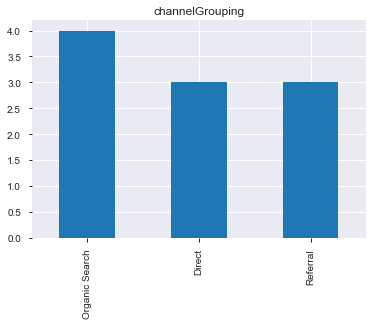

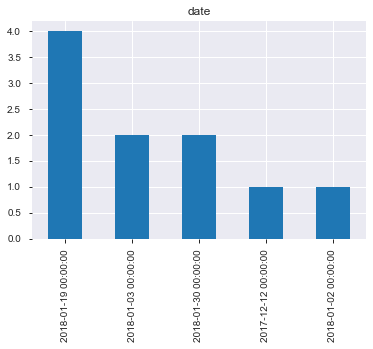

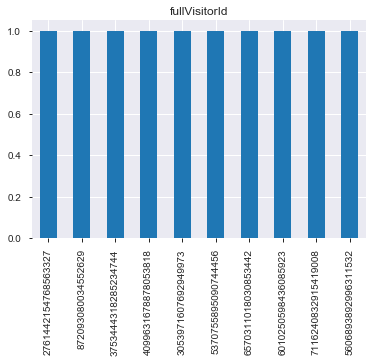

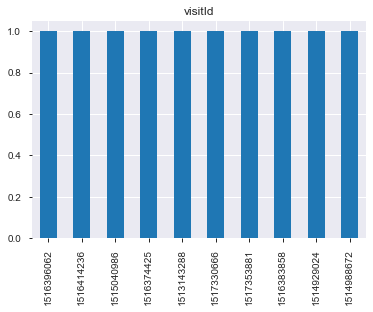

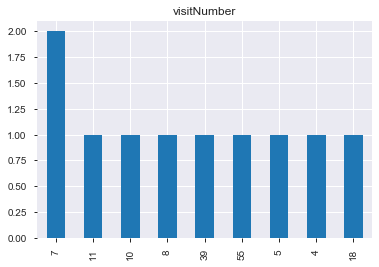

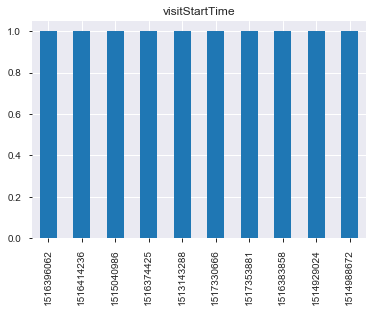

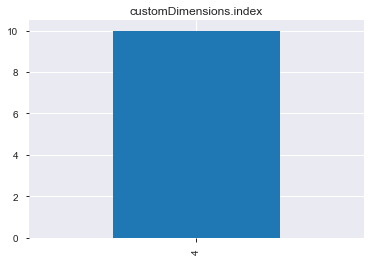

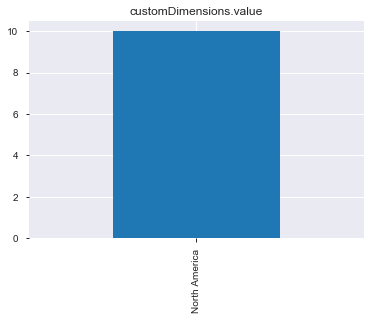

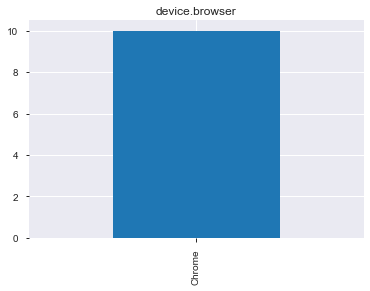

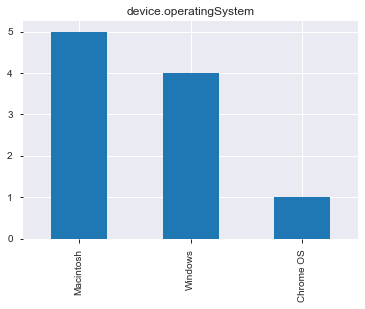

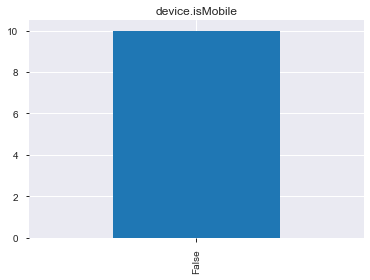

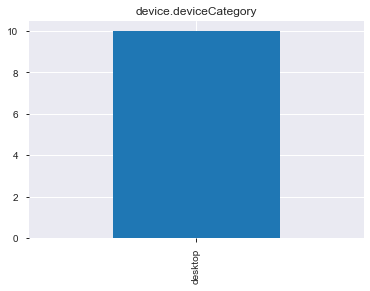

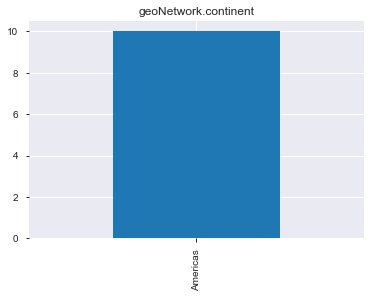

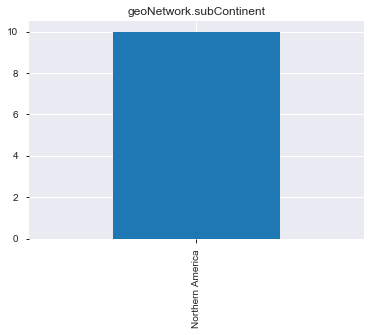

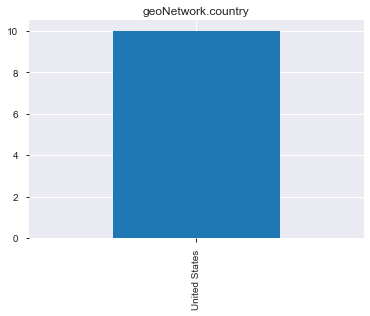

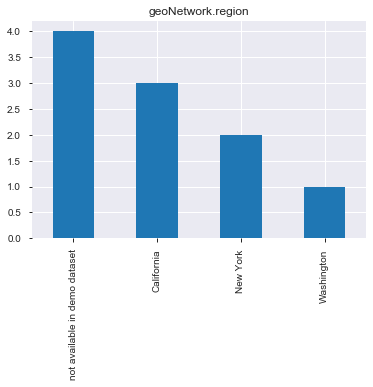

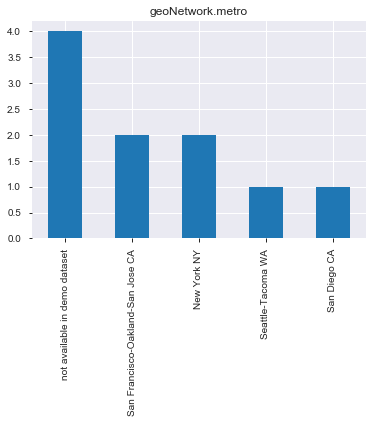

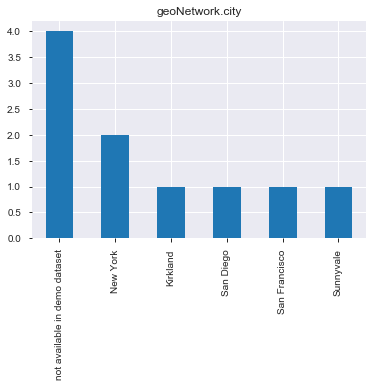

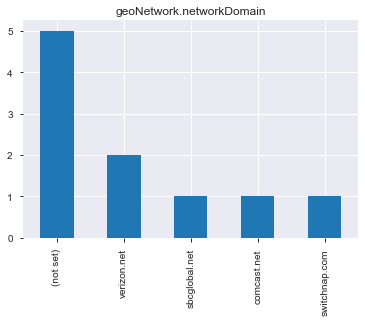

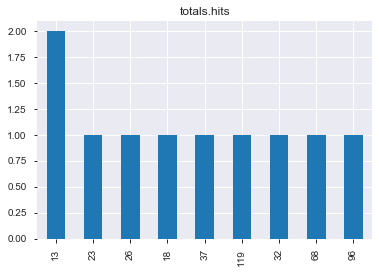

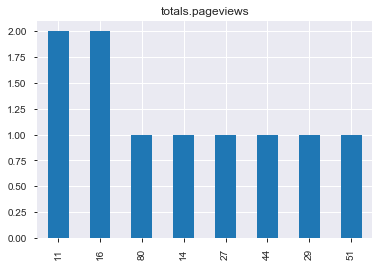

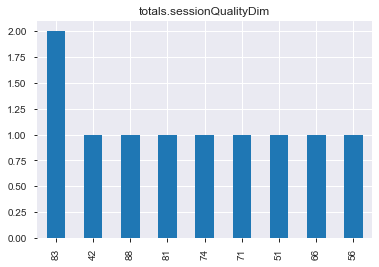

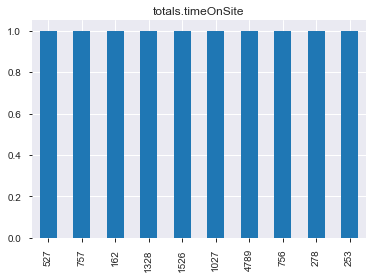

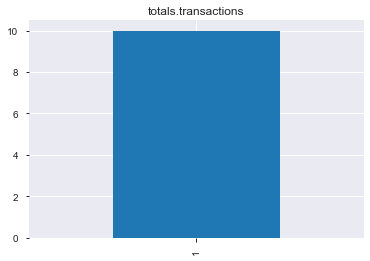

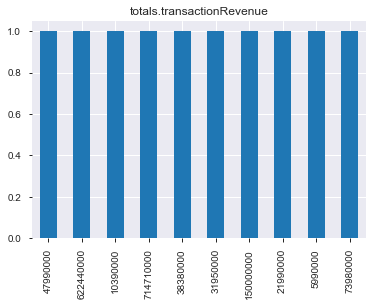

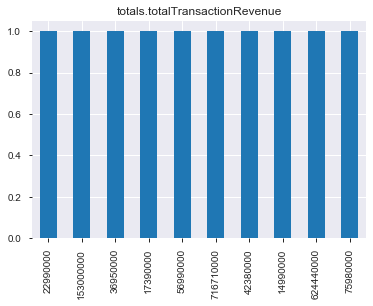

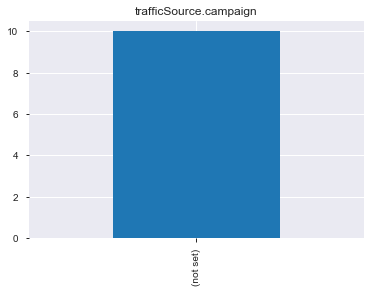

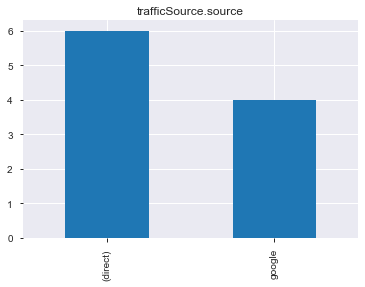

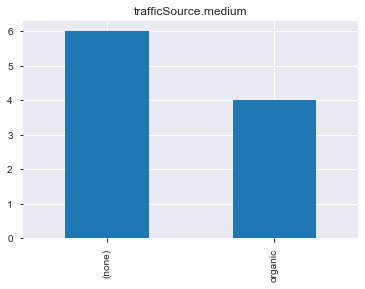

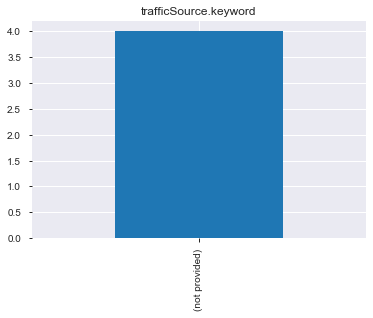

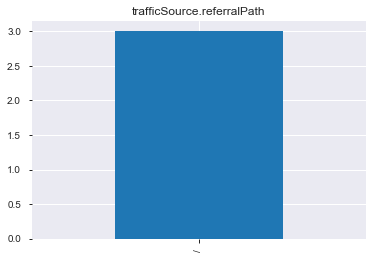

TypeError: no numeric data to plot

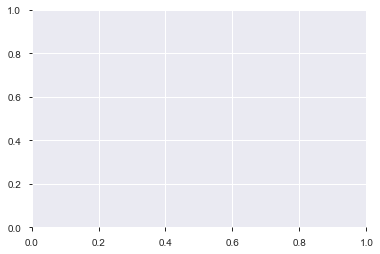

In [671]:
for column in list(period2_returnedCustomers.columns):
    plt.figure()
    period2_returnedCustomers[column].value_counts().plot(kind='bar', title=column)
    plt.show()

## Pick features that seem to be relevant:

In [80]:
rel_features_categ = ['channelGrouping','device.browser','device.operatingSystem','device.isMobile','geoNetwork.continent','trafficSource.source','trafficSource.medium']
rel_features_num = ['fullVisitorId','date','visitNumber', 'visitStartTime','totals.sessionQualityDim', 'totals.hits','totals.pageviews', 'totals.timeOnSite','totals.transactionRevenue']

In [81]:
period1_df_rel_features_categ = period1_df[rel_features_categ]
period1_df_rel_features_num = period1_df[rel_features_num]

period2_df_rel_features_categ = period2_df[rel_features_categ]
period2_df_rel_features_num = period2_df[rel_features_num]

Get dummies of categorial values:

In [82]:
period1_df_rel_features_categ_dummies = pd.get_dummies(period1_df_rel_features_categ)

period2_df_rel_features_categ_dummies = pd.get_dummies(period2_df_rel_features_categ)

Combine categorial dummies and numerical dataframes:

In [83]:
period1_input_df = pd.concat([period1_df_rel_features_num, period1_df_rel_features_categ_dummies], axis=1, sort=False).fillna(0)

period2_input_df = pd.concat([period2_df_rel_features_num, period2_df_rel_features_categ_dummies], axis=1, sort=False).fillna(0)

Drop uniquie features (columns) from both periods data frames:

In [84]:
columns_intersec = set(period1_input_df.columns).intersection(set(period2_input_df.columns))

In [85]:
period1_input_df = period1_input_df[columns_intersec]
period2_input_df = period2_input_df[columns_intersec]

## Compare data frames

Only use rows for `period1_input_df` and `period2_input_df` which have `fullVisitorId` in both data frames:

In [86]:
period1_input_df = period1_input_df[period1_input_df['fullVisitorId'].isin(period2_input_df['fullVisitorId'])].dropna().reset_index(drop=True)
period2_input_df = period2_input_df[period2_input_df['fullVisitorId'].isin(period1_input_df['fullVisitorId'])].dropna().reset_index(drop=True)

print(period1_input_df['fullVisitorId'].nunique(), 'unique visitors appear in period 1 as well as period 2.')

238 unique visitors appear in period 1 as well as period 2.


## Convert transactionsrevenue by natural log

In [34]:
np.log(period1_input_df['totals.transactionRevenue'].astype(float)+1)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
587    0.0
588    0.0
589    0.0
590    0.0
591    0.0
Name: totals.transactionRevenue, Length: 592, dtype: float64

## Add feature that gives the gradient of the spending for each user over time

- transform datetime to ordinal values:

In [87]:
period1_input_df['date'] = pd.to_datetime(period1_input_df['date']).apply(lambda date: date.toordinal())
period2_input_df['date'] = pd.to_datetime(period2_input_df['date']).apply(lambda date: date.toordinal())

In [581]:
test1=period1_input_df[period1_input_df['fullVisitorId'] == period1_input_df['fullVisitorId'][8]][['date_ordinal','totals.transactionRevenue']].reset_index(drop=True)

In [592]:
test1['totals.transactionRevenue']=test1['totals.transactionRevenue'].astype(float)

(0, 1196740001.0)

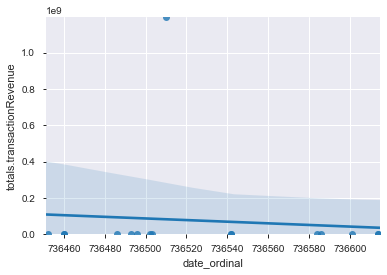

In [593]:
ax = sn.regplot(
    data=test1,
    x='date_ordinal',
    y='totals.transactionRevenue',
)
# Tighten up the axes for prettiness
ax.set_xlim(test1['date_ordinal'].min() - 1, test1['date_ordinal'].max() + 1)
ax.set_ylim(0, test1['totals.transactionRevenue'].max() + 1)

In [559]:
for index in list(range(len(period1_input_df['fullVisitorId']))):
    if period1_input_df['fullVisitorId'][index] in list(period1_input_df['fullVisitorId'])[(1+index):]:
        period1_input_df['gradient'][index] = period1_input_df[period1_input_df['fullVisitorId'] == period1_input_df['fullVisitorId'][index]]['totals.transactionRevenue']
    else: period1_input_df['gradient'][index] = 0

/Users/Marvin/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Incompatible indexer with DataFrame

In [488]:
for duplicates in period1_input_df['fullVisitorId'].duplicated():
    if duplicates == True:
        print(duplicates)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


(0, 388)

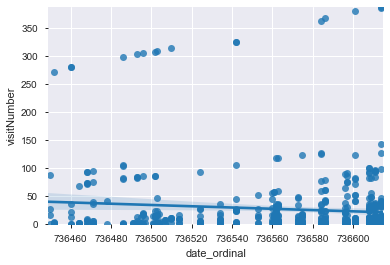

In [569]:
ax = sn.regplot(
    data=period1_input_df,
    x='date_ordinal',
    y='visitNumber',
)
# Tighten up the axes for prettiness
ax.set_xlim(period1_input_df['date_ordinal'].min() - 1, period1_input_df['date_ordinal'].max() + 1)
ax.set_ylim(0, period1_input_df['visitNumber'].max() + 1)

Drop column `fullVisitorId`:

In [88]:
period1_input_df = period1_input_df.drop(columns='fullVisitorId')
period2_input_df = period2_input_df.drop(columns='fullVisitorId')

# Random forest
(Guide found [here](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0))

## Create input numpy arrays:

In [91]:
# Labels are the values we want to predict
train_labels = np.array(period1_input_df['totals.transactionRevenue'])

# Remove the labels from the features
# axis 1 refers to the columns
period1_input_df = period1_input_df.drop('totals.transactionRevenue', axis = 1)

# Saving feature names for later use
feature_list = list(period1_input_df.columns)

# Convert to numpy array
period1_input_df = np.array(period1_input_df)

In [92]:
# train dataframe (period 2)

# Labels are the values we want to predict
test_labels = np.array(period2_input_df['totals.transactionRevenue'])

# Remove the labels from the features
# axis 1 refers to the columns
period2_input_df = period2_input_df.drop('totals.transactionRevenue', axis = 1)

# Convert to numpy array
period2_input_df = np.array(period2_input_df)

In [21]:
# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
#train_features, test_features, train_labels, test_labels = train_test_split(period1_input_df, labels, test_size = 0.25, random_state = 42)

We can look at the shape of all the data to make sure we did everything correctly. We expect the training features number of columns to match the testing feature number of columns and the number of rows to match for the respective training and testing features and the labels:

In [93]:
print('Training Features Shape:', period1_input_df.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', period2_input_df.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (592, 124)
Training Labels Shape: (592,)
Testing Features Shape: (394, 124)
Testing Labels Shape: (394,)


## Load Random forest regressor:

In [154]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(period1_input_df, train_labels);

## Make Predictions on the Test Set:

In [155]:
# Use the forest's predict method on the test data
predictions = rf.predict(period2_input_df)

# Calculate the absolute errors
errors = abs(np.log(predictions+1) - np.log(test_labels.astype(float)+1))

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'dollars.')

Mean Absolute Error: 1.28 dollars.


## Variable importance

In [156]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

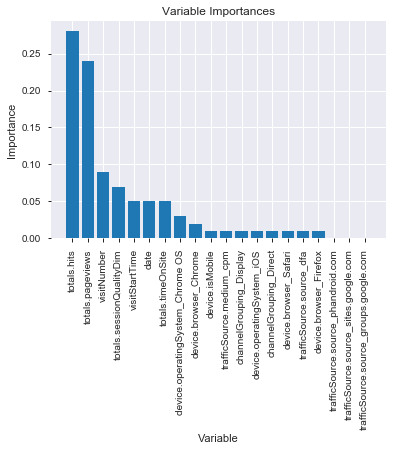

In [157]:
feat = list(zip(*feature_importances))[0][:20]
imp = list(zip(*feature_importances))[1][:20]

# list of x locations for plotting
x_values = list(range(len(imp)))
# Make a bar chart
plt.bar(x_values, imp, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feat, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [98]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(np.log(test_labels.astype(np.float)+1),np.log(predictions+1)))

4.394676698927515

In [99]:
math.sqrt(mean_squared_error(np.log(test_labels.astype(np.float)+1),np.zeros(len(test_labels))))

2.8566173818806533

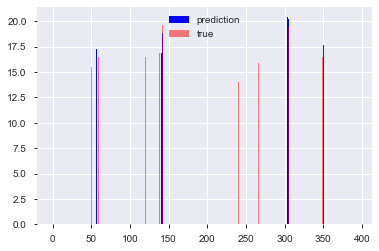

In [161]:
width = .8

a   = list(np.log(test_labels.astype(int)+1))
b    = np.log(predictions+1)

indices = np.arange(len(a))

plt.bar(indices, a, width=width, 
        color='b', label='prediction')
plt.bar([i+0.25*width for i in indices], b, 
        width=0.5*width, color='r', alpha=0.5, label='true')

plt.legend()

plt.show()
